## Swing outcomes
Once a batter swings at a pitch, there several possible outcomes: a swinging strike, a foul ball, or a ball put in play.

What characteristics of a pitch lead to those different outcomes?

For now, we'll ignore specific in-play outcomes (groundball out, home run, etc.), as lots of work has already been done in those areas.

In [1]:
# Import the necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# PITCHfx data from 2016 Jun 1–3, parsed using the `pfx_parser_csv.py` script
data = pd.read_csv('edited_pitch_table.csv')

In [ ]:
data.head()     # To see what the data looks like

In [ ]:
list(data)     # Returns all column headers

In [ ]:
data.shape
# 64 features
# 12,134 samples (pitches) in this three day period

In [ ]:
#Split dataset into fouls and not-fouls
thefouls = data[data['pitch_res'] == 'F']
notfouls = data[data['pitch_res'] != 'F']
print('Fouls: ', thefouls.shape, 'Not Fouls: ', notfouls.shape)
# 2050 pitches were fouled off, 10,084 were not fouled off, unbalanced dataset.

Let's just focus on the outcomes we're interested in, excluding balls and called strikes.

In [6]:
data = data[data.pitch_res != 'C']
data = data[data.pitch_res != 'B']
data.shape

(5630, 64)

### Encoding the categorical variables

Several features are categorical, so they need to be encoded as 0/1s for each possible value

In [ ]:
# Which features are categorical?
X.dtypes
# Pitcher hand, batter hand, pitch sequence, pitch type, pitch type sequence

In [8]:
# Use pd.get_dummies() to encode these categorical variables
catcols = ['pit_hand_cd', 'bat_hand_cd', 'pitch_type']
hots = pd.get_dummies(data, columns=catcols, prefix = catcols)
hots.head()
# Seems to work!

,retro_game_id,year,st_fl,regseason_fl,playoffs_fl,game_type,game_type_des,game_id,home_team_id,home_team_lg,...,pitch_type_EP,pitch_type_FC,pitch_type_FF,pitch_type_FO,pitch_type_FS,pitch_type_FT,pitch_type_KC,pitch_type_KN,pitch_type_SI,pitch_type_SL
4,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,1,0,0,0,0,0,0,0,0
7,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,0,0,0,0,0,0,0,0,0
8,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,0,0,0,0,0,0,0,0,0
15,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,0,1,0,0,0,0,0,0,0
16,HOU201606010,2016,F,T,F,R,Regular Season,447654,hou,AL,...,0,0,1,0,0,0,0,0,0,0


In [9]:
# Some rows have missing values, so drop them (not sure exactly where/what they are right now)
hots = hots.dropna()
hots.shape    # 7 samples dropped, due to the encoding, not sure why?

(5623, 77)

In [10]:
# Split data into X and y
'''We can look at all pitch outcomes first, then later focus on just fouls'''
y = hots['pitch_res']
# X needs to exclude old encoded columns, but also stuff like the gameID, teamIDs, etc...
dropcols = [
    'retro_game_id',
    'year',
    'st_fl',
    'regseason_fl',
    'playoffs_fl',
    'game_type',
    'game_type_des',
    'game_id',
    'home_team_id',
    'home_team_lg',
    'away_team_id',
    'away_team_lg',
    'interleague_fl',
    'park_name',
    'park_lock',
    'pitch_seq',      # Too difficult to encode, unfortunately...
    'pa_terminal_fl',
    'pa_event_cd',
    'pitch_res',
    'pitch_des',
    'pitch_id',
    'pitch_type_seq',    # Too difficult to encode, unfortunately...
    'sv_id',
    'x', 'y',     # Older, less useful PitchFX features, now replaced by 'px' and 'pz'
    'y0'          # Distance between the pitcher's release point and home plate, held constant by definition in the PitchFX data
]
X = hots.drop(dropcols, axis=1)
print('X: ', X.shape, 'y: ', y.shape)

X:  (5623, 51) y:  (5623,)


In [11]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
# Fit a Random forest classifier to the training set
pitchresultsforest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
pitchresultsforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [13]:
pitchresultsforest.score(X_test, y_test)
# 3 possible outcomes right now, so .46 is better than chance (0.33), but not great

0.46713362068965519

In [14]:
# Feature importances
colsX = pd.Series(X_test.columns.values)
imps = pd.concat([colsX, pd.Series(pitchresultsforest.feature_importances_)], axis=1).reset_index()
imps.columns = ['index', 'feature', 'importance']
imps.sort_values(by='importance', ascending=0)   # Sorted by importance

,index,feature,importance
19,19,pz,0.072012
18,18,px,0.041409
24,24,vz0,0.040093
26,26,ay,0.034977
34,34,spin_rate,0.034519
22,22,vx0,0.034510
21,21,z0,0.034453
20,20,x0,0.033980
4,4,bat_id,0.033888
31,31,type_conf,0.033135


## Random forest classification: all pitch outcomes
* Looked at ALL pitch outcomes (swinging/called strike, ball, foul, in play, etc.)
* **Most important features**:
    * Pitch location (zone, px, pz), particularly height (pz)
    * Velocity (vz0, vx0)
    * Release point (x0, z0), this is somewhat surprising to me
    * The batter involved (bat_id)
    * Strike count
* **Non-important features**:
    * Batter/pitcher handedness
    * Pitch type!
    * Game situation (inning, number of outs, men on base, etc.)
    * Park effects

I think these are pretty intuitive results, but it's cool to see them quantified!

Should look into exactly what pitch locations, velocities, etc. lead to each outcome.

Next though, rather than consider all pitch outcomes, let's focus exclusively on fouled vs. not-fouled pitches.

In [15]:
#Use pd.get_dummies() again to easily draw out the fouled-off balls
possres = list(set(y))
outcomes = pd.get_dummies(y, columns=possres)
fouls = outcomes['F']

In [16]:
'''IMPORTANT: Create sample weights to rebalance the data!'''
numnotfoul = len(fouls[fouls == 0])
numfoul = len(fouls[fouls == 1])
coefweight = numnotfoul / numfoul
print(coefweight)   # ~1.74x more not-fouls than fouls (will differ slightly with each train/test split)
sampweight = fouls.replace(0, coefweight)

1.7469467513434294


In [17]:
# Train/test split with fouls this time instead of full y
X_train, X_test, y_train, y_test, samp_train, samp_test = train_test_split(X, fouls, sampweight, test_size=0.33, random_state=42)

In [18]:
# Random Forest Classification on foul T/F
foulforest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=2)
foulforest.fit(X_train, y_train, sample_weight = samp_train.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=2, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [19]:
# Need to include sample weights when assessing accuracy now
foulforest.score(X_test, y_test, sample_weight=samp_test.values)
# accuracy of 0.69, not so great

0.68988147168885849

In [20]:
# Feature importances, if interested
colsX = pd.Series(X_test.columns.values)
imps = pd.concat([colsX, pd.Series(foulforest.feature_importances_)], axis=1).reset_index()
imps.columns = ['index', 'feature', 'importance']
imps.sort_values(by='importance', ascending=0)   # Sorted by importance

,index,feature,importance
19,19,pz,0.045182
21,21,z0,0.039051
18,18,px,0.038714
24,24,vz0,0.037903
26,26,ay,0.037109
34,34,spin_rate,0.036954
31,31,type_conf,0.036343
22,22,vx0,0.036273
20,20,x0,0.035957
4,4,bat_id,0.035419


## Random forest classification: foul T/F

The model seems pretty accurate as classifying pitches as fouls or not-fouls!

However, the feature importance is not terribly informative. Location seems to matter to a small degree (px/pz).

I'm not clear how the 'ay' feature (acceleration from the pitcher's mound to home plate) substantively differs from velocity (vy0), but apparently it is much more important feature.

It may help to delve into how each individual feature affects these pitch outcomes. Coming soon!

The importance of 'type_conf' is really interesting to me. That feature is PITCHfx's own confidence in classifying that pitch's type. While that seems purely technical, perhaps that confidence affects batters as well, and their ability to react properly or make good contact. Would like to look into this more as well.

## Linear Discriminant Analysis

Let's visualize the differences between pitch outcomes, using Linear Discriminant Analysis.


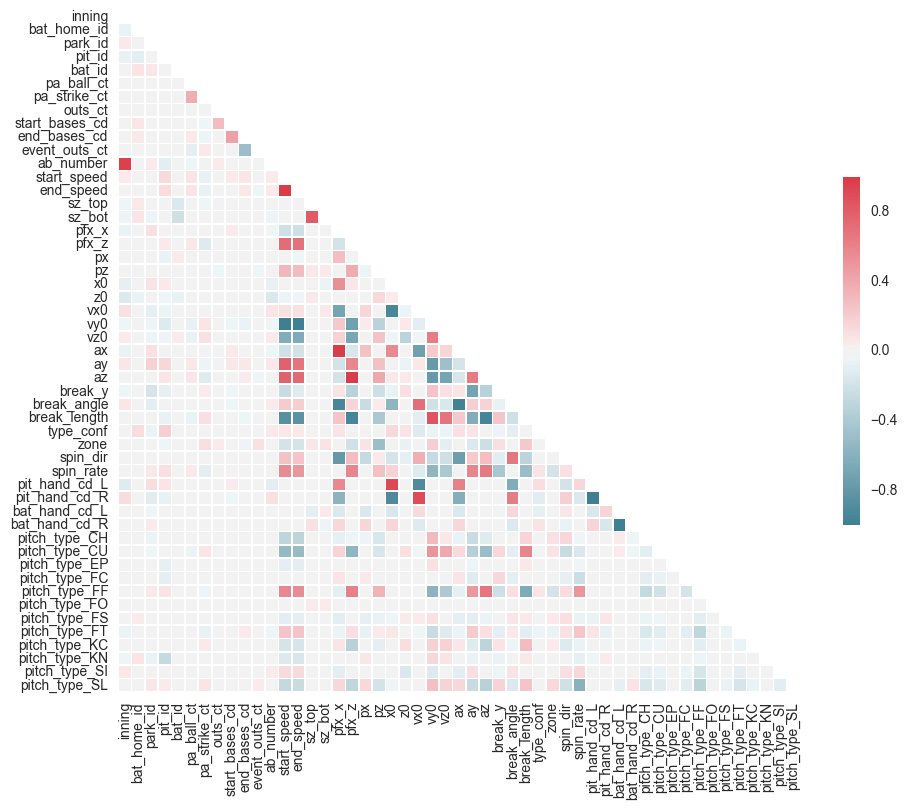

In [21]:
# How are the features correlated with one another? Need to withdraw some features for LDA to work best.
sns.set(style="white")

corr = X.corr()

# Mask for upper part of figure
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            #xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Correlated features:
* start/end bases situation
* velocity and acceleration between axes and each other
* spin rate/direction
* handedness
* pitch types with their characteristics (velocity, break, etc.)
* start/end speed
* break angle/length

In [62]:
# Drop some of these correlated features
dropcor = [
    'end_bases_cd',
    'spin_dir',
    'pit_hand_cd_L',
    'bat_hand_cd_L',
    'start_speed',
    'break_length',
    'x0',
    'vx0', 'vy0',
    'ay',
    'sz_bot',
    'vx0', 'vy0', 'vz0'
]

sparseX = X.drop(dropcor, axis=1)

## Selecting interesting pitch outcomes

There are five possible pitch outcomes (`['Ball', 'Foul', 'In play', 'Called strike', 'Swinging strike']`).

Trying to separate all of them in an LDA could get pretty messy.

What are some sets that make sense to compare?

Fouls vs. swinging-strikes vs. in-play could be interesting! Basically, this comparison looks at the outcomes of a batter swinging. Do they make contact? If so, is it in-play or foul? So let's focus on that subset.

In [ ]:
# Subsetting the dataset to focus on those outcomes
# Alternatively, just ignore those classes?

In [22]:
# Encode pitch outcomes
le = preprocessing.LabelEncoder()
ency = le.fit_transform(y)

In [64]:
lda = LinearDiscriminantAnalysis(n_components=2)    #n_components is basically the # of axes

foultf = lda.fit_transform(sparseX, ency)

'''
Warning that variables are collinear, could therefore under-estimate separation between groups
Should select features based on the correlation chart above
'''

/usr/local/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


'\nWarning that variables are collinear, could therefore under-estimate separation between groups\nShould select features based on the correlation chart above\n'

In [32]:
set(y)

{'F', 'S', 'X'}

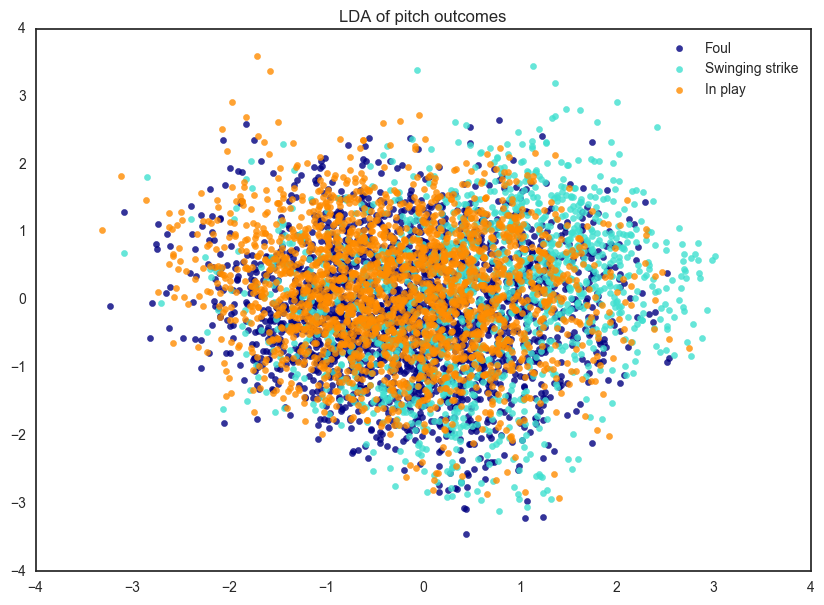

In [65]:
plt.figure(figsize = (10,7))
colors = ['navy', 'turquoise', 'darkorange']
outcomes = ['Foul', 'Swinging strike', 'In play']
lw = 2
for color, i, cat in zip(colors, [0,1,2,3,4], outcomes):
    plt.scatter(foultf[ency == i, 0], foultf[ency == i, 1], alpha=.8, color=color,
                label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of pitch outcomes')
plt.show()

In [85]:
#Weight vectors
colsX = pd.Series(sparseX.columns.values)
imps = colsX
for i in range(3):
    imps = pd.concat([imps, pd.Series(lda.coef_[i])], axis=1)
imps.columns = ['Feature', 'Foul', 'Swinging strike', 'In play']
imps = imps.set_index('Feature')
imps['Total'] = imps.abs().sum(axis=1)    # Take the absolute value of each weight, then sum them (but retain the original pos/neg signs in the table)
imps.sort_values(by='Total', ascending=0)   # Sorted by importance

,Foul,Swinging strike,In play,Total
Feature,,,,
break_y,-1.722391e-02,-1.936531e+00,1.305338e+00,3.259093e+00
pitch_type_FO,-3.218300e-01,4.391829e-01,1.452896e-02,7.755419e-01
pitch_type_SI,5.099635e-02,-3.956299e-01,2.147022e-01,6.613284e-01
pitch_type_FT,7.520712e-02,-3.786020e-01,1.802857e-01,6.340948e-01
event_outs_ct,-5.522546e-02,3.745905e-01,-1.966666e-01,6.264826e-01
pitch_type_SL,-8.696844e-02,3.635067e-01,-1.590250e-01,6.095001e-01
pitch_type_CU,-2.020751e-01,3.149626e-01,-1.696963e-02,5.340073e-01
pitch_type_CH,-7.936060e-02,2.787242e-01,-1.098490e-01,4.679338e-01
pitch_type_KN,-3.925454e-02,-2.298177e-01,1.903883e-01,4.594605e-01
